In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats

import warnings

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather")
se = se.set_index(se.columns[0])

In [3]:
se = se.dropna(subset=['median_durations_by_segment_code_and_hour_and_day'])



In [4]:
se['prev_timingPoint'] = se['prev_timingPoint'].astype(float).astype(int)

In [5]:
# se.iloc[1978]

In [6]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [7]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [8]:
def make_prediction(medians, results):
    return medians * (1 + (results / 100))




## Looking at Noise now

Starting by making some more medians to compare

In [9]:
se['dry'] = (se['rain'] == 0)
se['weekend'] = (se['arrival_day'] > 4)

In [10]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

median_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [17]:
mean_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .mean()
    .rename("mean_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    mean_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [15]:
median_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [21]:
mean_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .mean()
    .rename("mean_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    mean_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [ ]:
# prev_stopCode_and_public_name_and_hour_and_daytype_groups = se[se["train"]].groupby(
#     ["prev_stopCode", "arrival_hour", "weekend", "publicName"]
# )

# median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype = (
#     prev_stopCode_and_public_name_and_hour_and_daytype_groups["segment_duration"]
#     .median()
#     .rename("median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype")
# )

# se = se.merge(
#     median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype.to_frame(),
#     "left",
#     left_on=["prev_stopCode", "arrival_hour", "weekend", "publicName"],
#     right_index=True,
# )

In [ ]:
# segment_code_and_hour_and_daytype_dry_groups = se[se["train"]].groupby(
#     ["segment_code", "arrival_hour", "weekend", "dry"]
# )

# median_durations_by_segment_code_and_hour_and_daytype_and_dry = (
#     segment_code_and_hour_and_daytype_dry_groups["segment_duration"]
#     .median()
#     .rename("median_durations_by_segment_code_and_hour_and_daytype_and_dry")
# )

# se = se.merge(
#     median_durations_by_segment_code_and_hour_and_daytype_and_dry.to_frame(),
#     "left",
#     left_on=["segment_code", "arrival_hour", "weekend", "dry"],
#     right_index=True,
# )

In [ ]:
# median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry = (
#     segment_code_and_hour_and_daytype_dry_groups["dwell_duration_prev"]
#     .median()
#     .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry")
# )

# se = se.merge(
#     median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry.to_frame(),
#     "left",
#     left_on=["segment_code", "arrival_hour", "weekend", "dry"],
#     right_index=True,
# )

In [42]:
segment_code_groups = se[se["train"]].groupby(
    ["segment_code"]
)

median_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code")
)

se = se.merge(
    median_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [43]:
mean_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .mean()
    .rename("mean_prev_dwell_by_segment_code")
)

se = se.merge(
    mean_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [59]:
mean_durations_by_segment_code = (
    segment_code_groups["segment_duration"]
    .mean()
    .rename("mean_durations_by_segment_code")
)

se = se.merge(
    mean_durations_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [19]:
se['diff_segment_and_median_by_segment_code_and_hour_and_daytype'] = se['segment_duration'] - se['median_durations_by_segment_code_and_hour_and_daytype']
se['diff_segment_and_mean_by_segment_code_and_hour_and_daytype'] = se['segment_duration'] - se['mean_durations_by_segment_code_and_hour_and_daytype']


In [72]:
se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['median_prev_dwell_by_segment_code_and_hour_and_daytype']
se['diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['mean_prev_dwell_by_segment_code_and_hour_and_daytype']
se['diff_prev_dwell_and_dwell_predict_rules_mean'] = se['dwell_duration_prev'] - se['dwell_predict_rules_mean']


In [23]:
segment_code_and_hour_and_daytype_groups = None
median_durations_by_segment_code_and_hour_and_daytype = None
median_prev_dwell_by_segment_code_and_hour_and_daytype = None
mean_durations_by_segment_code_and_hour_and_daytype = None
mean_prev_dwell_by_segment_code_and_hour_and_daytype = None

# prev_stopCode_and_public_name_groups = None
# median_durations_by_prev_stop_code_public_name = None
# segment_code_and_hour_and_daytype_dry_groups = None
# median_durations_by_segment_code_and_hour_and_daytype_and_dry = None
# median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry = None
# segment_code_groups = None
# median_prev_dwell_by_segment_code = None

In [24]:
se.columnsumns

Index(['id', 'date', 'stopCode', 'aimedArrival', 'aimedDeparture',
       'actualArrival', 'actualDeparture', 'vehicle', 'workid', 'patternId',
       ...
       'median_prev_dwell_by_segment_code_and_hour_and_daytype_y',
       'diff_segment_and_mediun_by_segment_code_and_hour_and_daytype',
       'median_prev_dwell_by_segment_code_and_hour_and_daytype',
       'diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype',
       'mean_durations_by_segment_code_and_hour_and_daytype',
       'mean_prev_dwell_by_segment_code_and_hour_and_daytype_y',
       'diff_segment_and_median_by_segment_code_and_hour_and_daytype',
       'diff_segment_and_mean_by_segment_code_and_hour_and_daytype',
       'mean_prev_dwell_by_segment_code_and_hour_and_daytype',
       'diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'],
      dtype='object', length=123)

## Mapes of various dwell predictions

In [25]:
print(f"Mean prev dwell: {np.mean(se['dwell_duration_prev'])}")
print(f"Median prev dwell: {np.median(se['dwell_duration_prev'])}")
print(f"Std prev dwell: {np.std(se['dwell_duration_prev'])}")

Mean prev dwell: 21.110430054021318
Median prev dwell: 7.0
Std prev dwell: 34.13694693912832


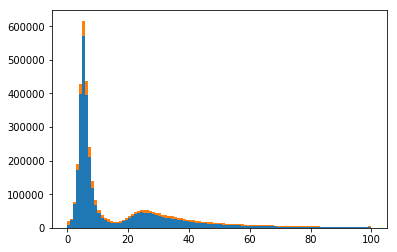

In [26]:
plt.hist([se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'], se.loc[se['prev_timingPoint'] == 1, 'dwell_duration_prev']], bins=100, stacked=True, range=(0,100));

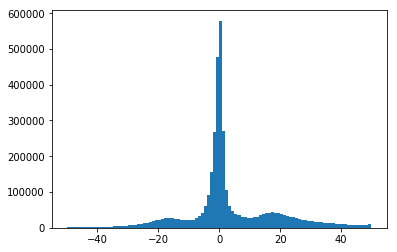

In [28]:
plt.hist(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], bins=100, range=(-50, 50));


In [29]:
np.mean(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'])


6.699865859440403

In [30]:
np.std(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'])


30.59059254678719

In [31]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_dwell_prev_durations_by_stop_code']).std()


36.939576731357434

## Looking at the bayesian esimates of some means and standard deviations travel times (median model)

In [32]:
stats.bayes_mvs(se['diff_segment_and_mediun_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=6.519326427502951, minmax=(6.490650088002942, 6.548002767002959)),
 Variance(statistic=1190.4820947086864, minmax=(1189.082829148334, 1191.8813602690389)),
 Std_dev(statistic=34.50336352746912, minmax=(34.483086293349054, 34.523640761589185)))

In [33]:
stats.bayes_mvs(se['median_durations_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=39.518300841991156, minmax=(39.4957706311002, 39.54083105288211)),
 Variance(statistic=734.8622783001719, minmax=(733.998537902733, 735.7260186976107)),
 Std_dev(statistic=27.108343333744536, minmax=(27.092412068841977, 27.124274598647094)))

In [34]:
stats.bayes_mvs(se['segment_duration'], alpha=0.9)

(Mean(statistic=46.0376272694941, minmax=(46.00007918648389, 46.07517535250432)),
 Variance(statistic=2041.037479589336, minmax=(2038.6384905870893, 2043.4364685915828)),
 Std_dev(statistic=45.17784279477426, minmax=(45.15129229065718, 45.20439329889133)))

In [35]:
(se['median_durations_by_segment_code_and_hour_and_daytype'] - se['median_durations_by_segment_code']).std()


9.884052374862756

In [54]:
# The standard devations of the diff_segment... and median_durations... roughly adds up 
# to the std of the raw segment_durations. This is probably a good thing. 

np.sqrt(34**2+27**2)

43.41658669218482

## Looking at the bayesian esimates of some means and standard deviations travel times (mean model)

In [55]:
stats.bayes_mvs(se['diff_segment_and_mean_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=0.1833254508219258, minmax=(0.15561127005849357, 0.21103963158535805)),
 Variance(statistic=1111.935335643217, minmax=(1110.628392155852, 1113.2422791305821)),
 Std_dev(statistic=33.34569440937191, minmax=(33.32609752421906, 33.36529129452476)))

In [56]:
stats.bayes_mvs(se['mean_durations_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=45.85430181867216, minmax=(45.82899711060366, 45.879606526740666)),
 Variance(statistic=926.9965201367368, minmax=(925.9069495241597, 928.0860907493138)),
 Std_dev(statistic=30.446617548370405, minmax=(30.42872441769922, 30.464510679041588)))

In [60]:
(se['mean_durations_by_segment_code_and_hour_and_daytype'] - se['mean_durations_by_segment_code']).std()

11.3157622683631

In [62]:
# Intesrtingly this model gets a little closer to the actual std of the segment durations

np.sqrt(33**2+30**2)

44.598206241955516

### Same with dwell times (median model)

In [63]:
stats.bayes_mvs(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=6.699865859440403, minmax=(6.674441491271892, 6.725290227608914)),
 Variance(statistic=935.7843523555207, minmax=(934.6844527249528, 936.8842519860885)),
 Std_dev(statistic=30.59059254665592, minmax=(30.572614803516583, 30.608570289795257)))

In [64]:
stats.bayes_mvs(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=14.410564194580916, minmax=(14.397537880940696, 14.423590508221135)),
 Variance(statistic=245.6509807778483, minmax=(245.36224820572733, 245.93971334996928)),
 Std_dev(statistic=15.673256865688392, minmax=(15.66404587097953, 15.682467860397255)))

In [65]:
stats.bayes_mvs(se['dwell_duration_prev'], alpha=0.9)

(Mean(statistic=21.110430054021318, minmax=(21.0820582496569, 21.138801858385737)),
 Variance(statistic=1165.3311463141363, minmax=(1163.9614426061253, 1166.7008500221473)),
 Std_dev(statistic=34.136946938971214, minmax=(34.11688504371064, 34.15700883423179)))

In [66]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_prev_dwell_by_segment_code']).std()

7.275457025428193

In [67]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_prev_dwell_by_segment_code']).abs().mean()

3.4243510050457173

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'dwell_duration_prev'], alpha=0.9)

### Same with dwell times (mean model)

In [77]:
stats.bayes_mvs(se['diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=-0.0637650065347085, minmax=(-0.0883780577567293, -0.0391519553126877)),
 Variance(statistic=877.0136484940496, minmax=(875.9828266112585, 878.0444703768406)),
 Std_dev(statistic=29.614416227473566, minmax=(29.59701217204878, 29.63182028289835)))

In [76]:
stats.bayes_mvs(se['mean_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=21.17419506055603, minmax=(21.159927771898083, 21.188462349213978)),
 Variance(statistic=294.6852084131716, minmax=(294.338842125841, 295.03157470050223)),
 Std_dev(statistic=17.166397653939267, minmax=(17.156309157380086, 17.176486150498448)))

In [70]:
(se['mean_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['mean_prev_dwell_by_segment_code']).std()

7.616998248805968

In [71]:
(se['mean_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['mean_prev_dwell_by_segment_code']).abs().mean()

4.067628745573474

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'], alpha=0.9)


In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'mean_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

### Same with dwell times (rules model)

In [78]:
stats.bayes_mvs(se['diff_prev_dwell_and_dwell_predict_rules_mean'], alpha=0.9)

(Mean(statistic=0.2879116850937417, minmax=(0.26360429834201765, 0.31221907184546577)),
 Variance(statistic=855.3659994751732, minmax=(854.3606217463677, 856.3713772039788)),
 Std_dev(statistic=29.24664082377963, minmax=(29.22945290577456, 29.263828741784696)))

In [79]:
stats.bayes_mvs(se['dwell_predict_rules_mean'], alpha=0.9)

(Mean(statistic=20.822518368927575, minmax=(20.808877036626484, 20.836159701228667)),
 Variance(statistic=269.3946817924847, minmax=(269.07804141456575, 269.7113221704036)),
 Std_dev(statistic=16.413247143465693, minmax=(16.403601264891172, 16.422893022040213)))

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'diff_prev_dwell_and_dwell_predict_rules_mean'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'dwell_predict_rules_mean'], alpha=0.9)

### Find the mean absolute difference and the standard devations of each pair of buses that do the same segment within 5 mins of each other.

In [80]:
se_segment_name_groups = se.groupby("segment_name")

In [81]:
differences = []
arrival_hours = []
weekend = []
dry = []
length = []
distance = []

for name, segment in se_segment_name_groups:
    
    segment = segment.sort_values("actualArrival")
    
    previous_bus = segment.shift(1)
    
    mask = (segment['actualArrival'] - previous_bus['actualArrival']) < pd.Timedelta("5 minute")
    
    differences.extend(segment[mask]['segment_duration'] - previous_bus[mask]['segment_duration'])
    
    arrival_hours.extend(segment[mask]['arrival_hour'])
    
    weekend.extend(segment[mask]['weekend'])
    
    dry.extend(segment[mask]['dry'])
    
    length.extend(segment[mask]['line_distance'])
    
    distance.extend(segment[mask]['to_centre_dist'])
    

In [82]:
differences = np.array(differences)
arrival_hours = np.array(arrival_hours)
weekend = np.array(weekend)
dry = np.array(dry)
length = np.array(length)
distance = np.array(distance)

In [83]:
length = len(differences)

print(length)

differences_filtered = np.sort(differences)[int(length/100):-int(length/100)]

print(len(differences_filtered))

1162190
1138948


In [84]:
stats.bayes_mvs(differences, alpha=0.9)

(Mean(statistic=-0.5941722093633571, minmax=(-0.6579173251373018, -0.5304270935894124)),
 Variance(statistic=1745.4863186986408, minmax=(1741.7199733741568, 1749.252664023125)),
 Std_dev(statistic=41.779017684701984, minmax=(41.733943081070706, 41.82409228833326)))

In [85]:
stats.bayes_mvs(differences_filtered, alpha=0.9)

(Mean(statistic=-0.3785221098768337, minmax=(-0.4157580492624969, -0.3412861704911706)),
 Variance(statistic=583.6789244843095, minmax=(582.4066983328948, 584.9511506357242)),
 Std_dev(statistic=24.159447934179074, minmax=(24.13311814893562, 24.18577771942253)))

In [86]:
np.mean(np.abs(differences))

18.613852296096162

In [87]:
np.median(np.abs(differences))

8.0

In [88]:
np.mean(np.abs(differences_filtered))

14.820106800310462

In [89]:
np.median(np.abs(differences_filtered))

7.0

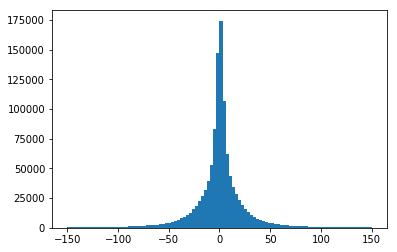

In [90]:
plt.hist(differences, bins=100, range=(-150, 150));

## Approach one, subtract the mean for each segment/hour/daytype

Try using both the mean and the median

In [ ]:
# mean_durations_by_segment_code_and_hour_and_daytype = (
#     segment_code_and_hour_and_daytype_groups["segment_duration"]
#     .mean()
#     .rename("mean_durations_by_segment_code_and_hour_and_daytype")
# )

# se = se.merge(
#     mean_durations_by_segment_code_and_hour_and_daytype.to_frame(),
#     "left",
#     left_on=["segment_code", "arrival_hour", "weekend"],
#     right_index=True,
# )

In [91]:
just_noise_median = se['diff_segment_and_median_by_segment_code_and_hour_and_daytype'].values

In [93]:
just_noise_mean = se['diff_segment_and_mean_by_segment_code_and_hour_and_daytype'].values

In [94]:
min_p, max_p = np.percentile(just_noise_median, [0.01,99.99])
just_noise_median_2_in_10000 = just_noise_median[(just_noise_median < max_p) & (just_noise_median > min_p)]

In [95]:
min_p, max_p = np.percentile(just_noise_mean, [0.01,99.99])
just_noise_mean_2_in_10000 = just_noise_mean[(just_noise_mean < max_p) & (just_noise_mean > min_p)]

In [98]:
just_noise_dwell_median = se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'].values

In [99]:
just_noise_dwell_mean = se['diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'].values

In [100]:
just_noise_dwell_rules = se['diff_prev_dwell_and_dwell_predict_rules_mean'].values

In [96]:
# From: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
# And then improved...

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True, range=(-100, 100))
    x = (x + np.roll(x, -1))[:-1] / 2.0
 
    dist_continu = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
#     dist_continu = ["cauchy", "johnsonsu", "tukeylambda", "norminvgauss", "t"] 

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    dist_results_name = []
    dist_results_p = []
    dist_results_D = []
    dist_results_sse = []
    dist_results_chi2_score = []
    dist_results_chi2_p = []
    params = {}

    # Estimate distribution parameters from data
    for dist_name in dist_continu:
        
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                dist = getattr(stats, dist_name)
                param = dist.fit(data)
                
                params[dist_name] = param
                D, p = stats.kstest(data, dist_name, args=param)

                # Separate parts of parameters
                arg = param[:-2]
                loc = param[-2]
                scale = param[-1]
                
                print(".", end="", flush=True)

                # Calculate fitted PDF and error with fit in distribution
                pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                chi2 = stats.chisquare(y, pdf)
                
                dist_results_name.append(dist_name)
                dist_results_p.append(p)
                dist_results_D.append(D)
                dist_results_sse.append(sse)
                dist_results_chi2_score.append(chi2[0])
                dist_results_chi2_p.append(chi2[1])
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = dist_name
                    best_params = param
                    best_sse = sse

        except Exception:
            pass
        
    sorted_idx = np.argsort(dist_results_sse)
    
    print("\nResults")
    for i in range(len(sorted_idx)):
        print(f"{dist_results_name[sorted_idx[i]]: <14},sse:{dist_results_sse[sorted_idx[i]]:0.6f} chi2:{dist_results_chi2_score[sorted_idx[i]]:0.6f} chi1_p:{dist_results_chi2_p[sorted_idx[i]]:0.6f} p:{dist_results_p[sorted_idx[i]]:0.4f} D:{dist_results_D[sorted_idx[i]]:0.4f}")
        

    return (best_distribution, best_params)

## Distribution fitting journey diffs, median model

.................................................................................................
Results
gennorm       ,sse:0.000698 chi2:0.074255 chi1_p:1.000000 p:0.0000 D:0.0732
tukeylambda   ,sse:0.000763 chi2:0.093113 chi1_p:1.000000 p:0.0000 D:0.0869
johnsonsu     ,sse:0.000787 chi2:0.029779 chi1_p:1.000000 p:0.0000 D:0.0442
t             ,sse:0.000912 chi2:0.101834 chi1_p:1.000000 p:0.0000 D:0.0875
cauchy        ,sse:0.000968 chi2:0.103575 chi1_p:1.000000 p:0.0000 D:0.0877
nct           ,sse:0.001290 chi2:0.054399 chi1_p:1.000000 p:0.0000 D:0.0480
norminvgauss  ,sse:0.001361 chi2:0.054237 chi1_p:1.000000 p:0.0000 D:0.0859
dweibull      ,sse:0.002928 chi2:0.139774 chi1_p:1.000000 p:0.0000 D:0.1365
dgamma        ,sse:0.005119 chi2:0.243830 chi1_p:1.000000 p:0.0000 D:0.1502
laplace       ,sse:0.008722 chi2:0.400338 chi1_p:1.000000 p:0.0000 D:0.1680
hypsecant     ,sse:0.012600 chi2:0.663808 chi1_p:1.000000 p:0.0000 D:0.1574
genlogistic   ,sse:0.014110 chi2:3.080069 chi1_p:1.000000 

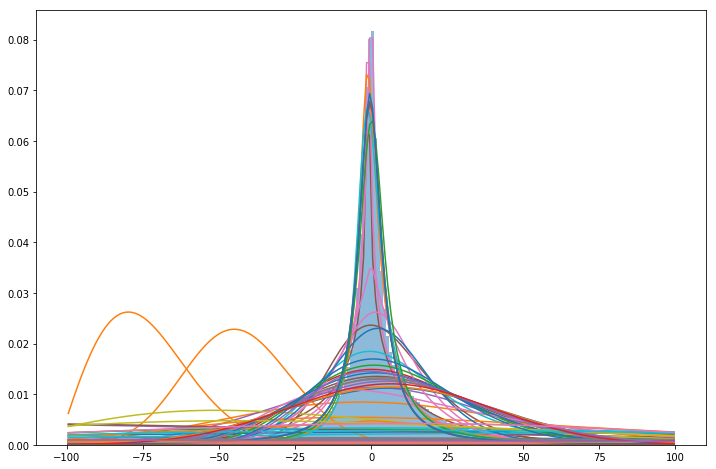

(0.5107187431289126, 5.644402672853895e-14, 1.9680290127324336)


In [97]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_median, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_median, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

In [ ]:
stats.cauchy.fit(just_noise_median)

In [ ]:
best_params

## Distribution fitting journey diffs, mean model

.................................................................................................
Results
cauchy        ,sse:0.000383 chi2:0.035326 chi1_p:1.000000 p:0.0000 D:0.0282
johnsonsu     ,sse:0.000409 chi2:0.024824 chi1_p:1.000000 p:0.0000 D:0.0209
tukeylambda   ,sse:0.000489 chi2:0.036119 chi1_p:1.000000 p:0.0000 D:0.0317
t             ,sse:0.000599 chi2:0.042852 chi1_p:1.000000 p:0.0000 D:0.0336
nct           ,sse:0.000734 chi2:0.042695 chi1_p:1.000000 p:0.0000 D:0.0230
gennorm       ,sse:0.000758 chi2:0.032076 chi1_p:1.000000 p:0.0000 D:0.0227
dweibull      ,sse:0.001151 chi2:0.050965 chi1_p:1.000000 p:0.0000 D:0.0304
dgamma        ,sse:0.001746 chi2:0.089220 chi1_p:1.000000 p:0.0000 D:0.0483
laplace       ,sse:0.004077 chi2:0.211815 chi1_p:1.000000 p:0.0000 D:0.0884
norminvgauss  ,sse:0.004472 chi2:0.177832 chi1_p:1.000000 p:0.0000 D:0.1731
hypsecant     ,sse:0.006610 chi2:0.391369 chi1_p:1.000000 p:0.0000 D:0.1138
fisk          ,sse:0.007734 chi2:0.494503 chi1_p:1.000000 

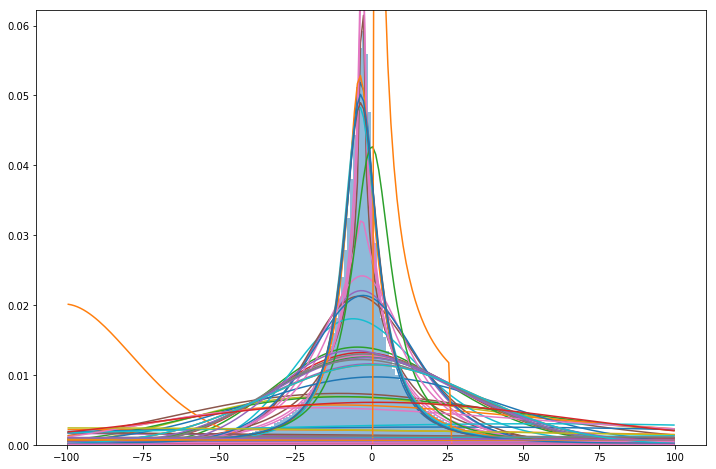

(-3.3987865683988967, 6.140268348920977)


In [101]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_mean, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_mean, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

## Distribution fitting dwell diffs, median model

.................................................................................................
Results
gennorm       ,sse:0.001933 chi2:0.376010 chi1_p:1.000000 p:0.0000 D:0.1555
t             ,sse:0.005885 chi2:0.554366 chi1_p:1.000000 p:0.0000 D:0.1465
tukeylambda   ,sse:0.005934 chi2:0.527986 chi1_p:1.000000 p:0.0000 D:0.1463
johnsonsu     ,sse:0.006472 chi2:0.309699 chi1_p:1.000000 p:0.0000 D:0.0851
nct           ,sse:0.007800 chi2:0.409366 chi1_p:1.000000 p:0.0000 D:0.0945
cauchy        ,sse:0.012298 chi2:0.632882 chi1_p:1.000000 p:0.0000 D:0.1583
norminvgauss  ,sse:0.013806 chi2:0.474492 chi1_p:1.000000 p:0.0000 D:0.1193
dgamma        ,sse:0.015316 chi2:0.670267 chi1_p:1.000000 p:0.0000 D:0.2039
dweibull      ,sse:0.016391 chi2:0.510498 chi1_p:1.000000 p:0.0000 D:0.2039
loglaplace    ,sse:0.024860 chi2:0.859606 chi1_p:1.000000 p:0.0000 D:0.2045
laplace       ,sse:0.025803 chi2:0.936124 chi1_p:1.000000 p:0.0000 D:0.2127
hypsecant     ,sse:0.031580 chi2:1.400665 chi1_p:1.000000 

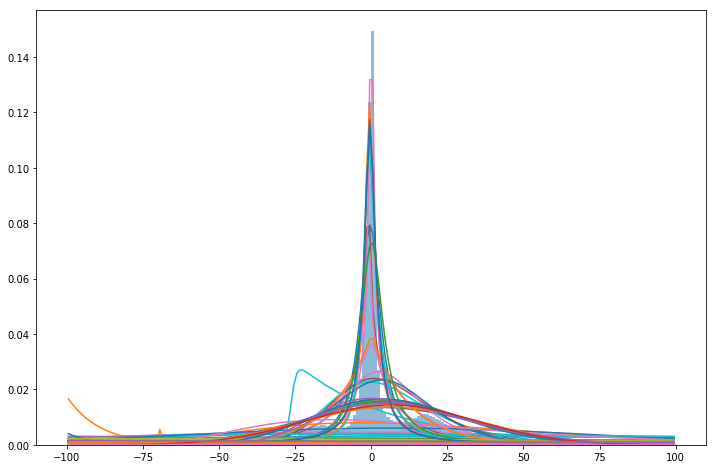

(0.23531435584758936, -6.018589028797858e-26, 0.007078991528151496)


In [102]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_dwell_median, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_dwell_median, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

## Distribution fitting dwell diffs, mean model

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_dwell_mean, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_dwell_mean, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

..........................

## Distribution fitting dwell diffs, rules model

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_dwell_rules, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_dwell_rules, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

## Using a method two on journey times

In [ ]:
stats.probplot(just_noise, sparams=(-0.3848045122209864, 4.753788866524921), dist="cauchy", plot=plt)

In [ ]:
stats.cauchy.fit(differences)

In [ ]:
rv = stats.cauchy(loc=0, scale=7.488655070821551/2)

In [ ]:
min_p, max_p = np.percentile(just_noise, [0.1,99.9])

x = np.linspace(-100,100, 200)
plt.plot(x, np.clip(rv.pdf(x), min_p, max_p))

## Analytic Noise Standard Deviation using distribution found from differences

In [ ]:
min_p, max_p = np.percentile(just_noise_median, [0.1,99.9])

samples = stats.cauchy.rvs(loc=0, scale=7.488655070821551/2, size=100000000)

# Deciding how/where to filter is quite a hack! 

print("######### HACK ##############")
samples_truncated = samples[(samples > min_p) & (samples < max_p)]
print("####### END HACK ############")

np.std(samples_truncated)

In [ ]:
len(samples_truncated)/len(samples)

In [ ]:
fig, ax1 = plt.subplots()

granularity = 300

ax1.hist(just_noise, bins=granularity, range=(-150, 150));

# ax2 = ax1.twinx()
x = np.linspace(-150, 150, granularity)
ax1.plot(x, stats.cauchy.pdf(x, -0.3848045122209864, 4.753788866524921) * len(just_noise), label="just noise")
ax1.plot(x, stats.cauchy.pdf(x, 0, 7.488655070821551/2) * len(just_noise), label="diffs")
ax1.legend()

## Analytic Noise Standard Deviation using Just Noise

In [ ]:
np.std(just_noise)

In [ ]:
np.std(just_noise_2_in_10000)

### Memory stuff

In [ ]:
se.memory_usage().sort_values()

In [ ]:
def exclude_columns_containing(se, to_remove):

    min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

    se_min = se[min_cols]

    return se_min


In [ ]:
se = exclude_columns_containing(se, ["prev_segment_code_",
            "next_segment_code_",
            "prev_event_index_",
            "next_event_index_",
            "offset_timestamp_5_"])

se = exclude_columns_containing(se, ["prev_stop_", "next_stop_", "road"])

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [ ]:
13149250104 - 4854970495